In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from scipy.sparse.linalg import svds
from scipy.spatial.distance import cosine 
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split


# Collaborative Filter 

## Data cleaning based on previous work
For the collaborative filter, I combined the business and reviews dataframe, subsetting restaurants in New Orleans, dropped irrelevant columns and filtered out users who have more than 100 reviews. Furthur data cleaning would involve getting rid of the restaurants tagged as automotive / bed and breakfast as I did for my baseline. We should also get rid of the "haters" that Analee found. 

In [3]:
path = '/Users/shafz/OneDrive/Documents/machine-learning-dse-i210-final-project-yelprestaurantrecommender/data/raw/'
business = pd.read_csv(path+'raw_business.csv')
restaurants = business[business.categories.fillna('-').str.lower().str.contains('restaurant')]

restaurants.columns = ['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'biz_stars', 'biz_review_count', 'is_open',
       'attributes', 'categories', 'hours']

restaurants = restaurants.drop(['address', 'state', 'postal_code',
       'latitude', 'longitude', 'is_open', 'attributes', 'hours'], axis = 1)

restaurants.shape

(52286, 6)

In [4]:
# removing irrelevant categories
lst = ['Automotive','Bed & Breakfast']  # categories we want to exclude 
rstr = '|'.join(lst)
idx_to_remove = restaurants[restaurants.categories.fillna('-').str.contains(rstr)].index
restaurants.drop(idx_to_remove, axis = 0, inplace=True)

restaurants.shape

(51934, 6)

In [5]:
reviews = pd.read_csv(path  + 'raw_reviews.csv')

In [6]:
reviews.drop('Unnamed: 0', axis =1, inplace = True)
reviews = reviews.drop(['useful', 'funny','cool','date'], axis = 1)

In [7]:
# merging business and reviews data together, filtering out the restaurants in New Orleans, and dropping duplicates
merged_df = pd.merge(reviews, restaurants, on='business_id')
nola = merged_df.loc[merged_df['city']=='New Orleans']
nola = nola.drop_duplicates(['user_id', 'business_id', 'stars'], keep='first')

In [8]:
## I'm going to focus my analysis on users that have at least 50 reviews and restaurants that have at least 50 reviews 
user_counts = nola['user_id'].value_counts().to_dict()
user_list = []

for key in user_counts.keys(): 
    if user_counts[key] >= 50: 
        user_list.append(key)

filtered_nola = nola[nola['user_id'].isin(user_list)]
print('Data shape after filtering by users: ', filtered_nola.shape)

biz_counts = filtered_nola['business_id'].value_counts().to_dict()
biz_list = []

for key in biz_counts.keys(): 
    if biz_counts[key] >= 25: 
        biz_list.append(key)

filtered_nola = filtered_nola[filtered_nola['business_id'].isin(biz_list)]
print('Data shape after also filtering by restaurants: ', filtered_nola.shape)
print('Unique users: ', len(filtered_nola['user_id'].unique()))
print('Unqiue businesses: ', len(filtered_nola['business_id'].unique()))

Data shape after filtering by users:  (30925, 10)
Data shape after also filtering by restaurants:  (19539, 10)
Unique users:  327
Unqiue businesses:  436


* Well.... after exclusing restaurants with less than 100 reviews, we are left with only 161 rows which is trash. I'm going to try filtering by restaurants with more than 25 restaurants and see what happens. 
* Okay, now we are at 3741 rows for 115 different restaurants ... not bad. What if I relax my constaint on the users from 100 to 50? 
* We have 19539 rows for 436 different businesses and 327 businesses. We have ended up with more data than if we filtered by users with more than 100 reviews so I am not sure if this helped in reducing the sparsity at all but we shall see

In [9]:
user_data = pd.read_csv(path + 'raw_users.csv')
user_stars = user_data[['user_id', 'average_stars']]

In [10]:
filtered_nola = pd.merge(filtered_nola, user_stars, on='user_id')
filtered_nola['stars'].value_counts()

4    7613
5    6173
3    3805
2    1432
1     516
Name: stars, dtype: int64

In [11]:
## create a dictionary which maps business id to restaurant name
biz_dict = {}
for row in filtered_nola.itertuples():
    biz_dict[row.business_id] = row.name

## Data Preparation

We are going to create a hold out set for evaluation 

In [12]:
train, test = train_test_split(filtered_nola, test_size =.10, random_state=42, shuffle=True)
train, val = train_test_split(train, test_size =.10, random_state=42, shuffle = True)

print('Train set len: ', len(train))
print('Test set len: ', len(test))
print('Val set len: ', len(val))

Train set len:  15826
Test set len:  1954
Val set len:  1759


Just going to do a sanity check to make sure all businesses and all users are represented in each split

In [13]:
print('# of Biz in Original set: ', len(filtered_nola['business_id'].unique()))
print('# of Biz in Train set: ', len(train['business_id'].unique()))
print('# of Biz in Test set: ', len(test['business_id'].unique()))
print('# of Biz in Val set: ', len(val['business_id'].unique()))

print('# of Users in Original set: ', len(filtered_nola['user_id'].unique()))
print('# of Users in Train set: ', len(train['user_id'].unique()))
print('# of Users in Test set: ', len(test['user_id'].unique()))
print('# of Users in Val set: ', len(val['user_id'].unique()))

# of Biz in Original set:  436
# of Biz in Train set:  436
# of Biz in Test set:  420
# of Biz in Val set:  419
# of Users in Original set:  327
# of Users in Train set:  327
# of Users in Test set:  320
# of Users in Val set:  324


Ideally, we want reviews for all the businesses in the train split. We also want all users in the train split. My reasoning behind this is that if we only see the business in the test or validation split, then we will not be able to make predictions for the user rating for that business based on the train set as we won't know what similar users rated that restaurant. Similarly, if we only see some users in the test or validation split, how can we calculate similar users for them? 

## Some Simple Baselines 

Just for comparisons sake, we are going to see what our root mean squared error (RMSE) and mean absolute error (MAE) come out to if we just predict the average business rating / average user rating every single time. Even though I can do this on the entire dataframe in one go since we are not training anything and theres no threat of information leakage in any way, I am still going to apply it to each split individually so we can compare easily later on

In [14]:
def predictAvgBiz(df, user = False):

    gt_stars = df['stars'].to_numpy()

    if user: 
        pred = df['average_stars'].to_numpy()
    else: 
        pred = df['biz_stars'].to_numpy()

    return (mean_squared_error(gt_stars, pred, squared=False), mean_absolute_error(gt_stars, pred))

In [15]:
### Predicting average business rating as user rating 

## evaluating train set 
train_rmse, train_mae = predictAvgBiz(train, user = False)
print('Train rmse: ', round(train_rmse, 2))
print('Train mae: ', round(train_mae, 2))
print('-------------------------------------')
## evaluating validation set 
val_rmse, val_mae = predictAvgBiz(val, user = False)
print('Val rmse: ', round(val_rmse, 2))
print('Val mae: ', round(val_mae, 2))
print('-------------------------------------')
## evaluating test set 
test_rmse, test_mae = predictAvgBiz(test, user = False)
print('Test rmse: ', round(test_rmse, 2))
print('Test mae: ', round(test_mae, 2))


Train rmse:  0.99
Train mae:  0.75
-------------------------------------
Val rmse:  1.0
Val mae:  0.76
-------------------------------------
Test rmse:  0.98
Test mae:  0.75


In [16]:
### Predicting average user rating as user rating 

## evaluating train set 
train_rmse, train_mae = predictAvgBiz(train, user = True)
print('Train rmse: ', round(train_rmse, 2))
print('Train mae: ', round(train_mae, 2))
print('-------------------------------------')
## evaluating validation set 
val_rmse, val_mae = predictAvgBiz(val, user = True)
print('Val rmse: ', round(val_rmse, 2))
print('Val mae: ', round(val_mae, 2))
print('-------------------------------------')
## evaluating test set 
test_rmse, test_mae = predictAvgBiz(test, user = True)
print('Test rmse: ', round(test_rmse, 2))
print('Test mae: ', round(test_mae, 2))

Train rmse:  0.94
Train mae:  0.73
-------------------------------------
Val rmse:  0.98
Val mae:  0.75
-------------------------------------
Test rmse:  0.94
Test mae:  0.73


## Building the Filter
For the collaborative filer, I 

* Created a pivot table where the rows are the users and the columns are the different restaurants. The value in each cell is the user rating for that restaurant.
* Calculated the sparsity 
* Normalized the data and set all NaNs to 0.
* Filled in the missing values using singular value decomposition (SVD) 
* Found most similar users using cosine similarity 
* Did some brief analysis on the results of the cosine similarity 
* Built a collaborative filter by combining the normalization, SVD reconstruction, and cosine similarity calculation
    * The collaborative filter finds the top five most similar users to a given user, calculates the average rating of restaurants that the similar users have visited but the user of interest has not and then recommends the top 5 restaurants with the highest ratings.
* Evaluaed performance using MSE and MAE
* Determined the optimal value of k based on the MSE and MAE 

### Preparing Data

In [17]:
def calcSparsity(df):
    number_of_empty = df.isnull().values.sum()
    total_number = df.size
    sparsity = number_of_empty/total_number
    print('Sparsity of train set: {}'.format(round(sparsity,3)))

def makePivot(df):
    user_ratings = df[['user_id', 'business_id', 'stars']]
    user_ratings_pivot = user_ratings.pivot_table(index='user_id', columns='business_id', values='stars', aggfunc='mean')
    return user_ratings_pivot

In [18]:
# creating pivot table with users as the row and restaurants as the columns
train_pivot = makePivot(train)
train_pivot.head()

## calculating sparsity 
calcSparsity(train_pivot)

Sparsity of train set: 0.894


### Filling in Missing Values with SVD

In [19]:
def compute_filled_matrix(pivot_df, k_val):
    """
    Takes in the number of latent vectors and outputs 
    a reconstructed/filled pivot table 
    """
    # Normalize pivot table 
    avg_ratings = pivot_df.mean(axis=1)
    user_ratings_centered = pivot_df.sub(avg_ratings, axis=0)
    user_ratings_centered = user_ratings_centered.fillna(0)
    user_ratings_centered.head()

    # Calculate SVD and use it to reconstruct the pivot table 
    U, sigma, Vt = svds(user_ratings_centered.to_numpy(), k = k_val, maxiter=1000, tol=0)
    sigma = np.diag(sigma)
    recalculated_ratings = np.dot(np.dot(U, sigma), Vt)
    recalculated_ratings = recalculated_ratings + avg_ratings.values.reshape(-1, 1)

    # Create a dataframe from the SVD recalculation 
    user_ratings_filled = pd.DataFrame(recalculated_ratings,
                                    index=pivot_df.index,
                                    columns=pivot_df.columns)

    return user_ratings_filled

In [20]:
user_ratings_filled_10 = compute_filled_matrix(train_pivot, 85)
user_ratings_filled_10.head()

business_id,-If0ps0QhOLCYVWQWs9RYg,-Tskf8WK17rb3ZfeFuRSWA,-VlBFlHwX-Pt6Xyzs9roGw,-fJPJP7iOd1ukDNqTSINIg,-psZLTe6IJTQUB-bZF7Zyg,06NHXjVHiGKNpZ2XeajVkA,0DdmKihJ90qKP5TAM3c2yQ,0KTwW1eC1YAjR-zDr8w4jA,0UJqTczta018RoktahC0jw,0ZeGH15LV98FuijA1XrWoA,...,yTJ2Ir6CMBzThLK5dmACvQ,yY3kq6_2m1FyY9MgaiHgoQ,ydmJoaK1PMlwLvMnbFXf1w,yf8a1DOlqoqlKHuLSKEfxg,yz0KWVamNhqiZGz7XTClzg,z0MXYel0okwMqLjgMkKD2A,zSqTndm5Alq9dW1PyzbdTA,zWfzgYe2nT9mHYm_vl1Ukw,zYyVEC0IF86xSHF3GFmvkg,zgpx6YqA7KeY9-3xbNEn3A
user_id,,,,,,,,,,,,,,,,,,,,,
-MRD72DXnVgjkM1AVFp7Nw,4.269776,4.539303,4.732025,4.152918,4.334207,4.530663,4.172755,4.202659,4.324333,4.129416,...,4.400794,4.187840,4.358658,4.576502,4.243549,4.253722,4.163117,4.272403,4.494391,2.895509
-SO_K8oLVH_9J23z2MtjGg,4.180020,4.363508,4.193494,4.396548,4.273439,4.249244,4.285399,4.269183,4.161129,4.175003,...,4.220517,4.314955,4.240888,4.047477,4.120437,4.473919,4.128756,3.893937,4.315949,4.268831
-Tg5YTEMbnYw3fQN99xKCQ,4.156352,4.160207,4.668192,4.270015,4.061256,4.178244,3.921790,4.148372,4.162931,4.247788,...,3.989793,4.073365,4.238189,4.236308,4.194891,4.328534,4.128994,4.408878,4.266174,4.027022
-V7frksbFjKQYVhrPnnlPw,3.913918,4.142510,4.625055,4.004805,4.175161,3.798052,4.151327,4.205051,4.101943,4.167470,...,3.943946,3.786857,4.081757,3.795563,3.879693,3.842452,3.669026,3.051177,4.214065,3.927767
-_Y8Mal7S750TsB6yMMDHA,4.124702,4.044610,4.064767,4.185289,4.045163,3.971815,3.877983,3.765346,3.832849,4.031527,...,3.870958,3.880856,3.985365,3.905356,3.951873,4.161423,3.964080,3.999848,4.087911,3.922546


What type of performance do we get if we just use the reconstructed matrix for predictions?

In [137]:
def evalTrain(train_pivot, kval):

    train_gt = train_pivot.iloc[:50, :100].values
    train_copy = train_pivot.copy()
    train_copy.iloc[:50, :100] = np.nan
    train_filled = compute_filled_matrix(train_copy, kval)
    mask = ~np.isnan(train_gt)
    preds = train_filled.iloc[:50, :100].values[mask]
    gt = train_gt[mask]

    return (train_filled, mean_squared_error(gt, preds), mean_absolute_error(gt, preds))

def evalVal(val_pivot, train_filled):

    train_val_overlap = train_filled[list(val_pivot.columns)]
    all_preds = []
    all_gt = []

    for user in val_pivot.index.values: 
        gt = val_pivot.loc[val_pivot.index==user].values
        preds = train_val_overlap.loc[train_val_overlap.index==user]

        mask = ~np.isnan(gt)
        preds = preds.values[mask]
        gt = gt[mask]

        all_preds.append(preds)
        all_gt.append(gt)

    preds = np.concatenate(all_preds)
    gt = np.concatenate(all_gt)

    return (mean_squared_error(gt, preds), mean_absolute_error(gt, preds))



In [141]:
## 
train_pivot = makePivot(val)
train_gt = train_pivot.iloc[:50, :100].values
train_copy = train_pivot.copy()
train_copy.iloc[:50, :100] = np.nan
train_filled = compute_filled_matrix(train_copy, 85)
mask = ~np.isnan(train_gt)
preds = train_filled.iloc[:50, :100].values[mask]
gt = train_gt[mask]

print('RMSE: ', mean_squared_error(gt, preds))
print('MAE: ', mean_absolute_error(gt, preds))

ValueError: Input contains NaN.

In [154]:
filtered_nola.loc[filtered_nola['user_id'] == '98Ed-IF0cLGSK-vtCesjOQ']

,review_id,user_id,business_id,stars,text,name,city,biz_stars,biz_review_count,categories,average_stars
7728,b1tgHM1MiOZBeX79aNGsnA,98Ed-IF0cLGSK-vtCesjOQ,jLerIZFpe25jOUf722qzBA,5,Just hit up Il Posto the other night after not...,Il Posto Italian Cafe,New Orleans,4.0,120,"Coffee & Tea, Food, Restaurants, Italian",3.62
7729,ATxlcyxG5RI0inw5CZaN_Q,98Ed-IF0cLGSK-vtCesjOQ,I0I2mkCOPTYVSLpc8A8VVw,3,"Very yummy, a bit loud, and not the best servi...",Compère Lapin,New Orleans,4.5,804,"Personal Chefs, Event Planning & Services, Res...",3.62
7730,-QwvmpencPcrhEVaXfZmDg,98Ed-IF0cLGSK-vtCesjOQ,wtwDcp79klLOLaIjCFHQCA,4,"Very, very, very good. Just not perfect. Yummy...",Saffron nola,New Orleans,4.5,297,"American (New), Bars, Cocktail Bars, Indian, A...",3.62
7731,T6l1MDzYxz4bxiBnyfAjnQ,98Ed-IF0cLGSK-vtCesjOQ,MqFQqNhMRaizyVRwsea6EA,4,Bratz Y'all is killin' it. I've been few times...,Bratz Y'all!,New Orleans,4.5,176,"German, Restaurants, Bakeries, Beer Gardens, F...",3.62
7732,2m8uzZk2Z4nC3HUD5ETsqQ,98Ed-IF0cLGSK-vtCesjOQ,UnQriKTiNsYnyPE3Rt8lTQ,3,My expectations were high as I'd heard lots of...,Tableau,New Orleans,4.0,1087,"Cajun/Creole, Wine Bars, Bars, Nightlife, Food...",3.62
7733,S3I2LQeUKte1Kkn-VElHcA,98Ed-IF0cLGSK-vtCesjOQ,9--QS5ChKDYf4POHKujoiw,3,We checked out ugly dog for some brunch Sunday...,Ugly Dog Saloon & BBQ,New Orleans,3.5,336,"Bars, Barbeque, Nightlife, American (Tradition...",3.62
7734,2U93O5__eMTHEDj_nzmQzQ,98Ed-IF0cLGSK-vtCesjOQ,2r3-fBAvSsljWrDLXkiHiw,4,I dig it. I've never had poke...this was my fi...,LemonShark Poke,New Orleans,4.5,113,"Restaurants, Food, Hawaiian, Vegan, Sushi Bars...",3.62
7735,vVlbvscoG85YxgsP-nzEzA,98Ed-IF0cLGSK-vtCesjOQ,_393npnr0Dw1aGKy83x_0A,4,Super impressed. The only reason my rating is ...,Paladar 511,New Orleans,4.5,507,"Restaurants, Pizza, American (New), Breakfast ...",3.62
7736,05ZPdjkXvAlia6tcgjVETA,98Ed-IF0cLGSK-vtCesjOQ,RPEMUwN_CDRRToQ_7hxsvA,5,Just revisited the other evening (my first tim...,Borgne,New Orleans,4.0,554,"Southern, Restaurants, Seafood, American (New)",3.62
7737,_5ewGkkHCzJjSOr-1tH4ng,98Ed-IF0cLGSK-vtCesjOQ,UGefDZNmnBztS0eoXWtHyQ,4,One of my favorites in the neighborhood! With ...,The Joint,New Orleans,4.5,1335,"Southern, Nightlife, Sandwiches, Barbeque, Res...",3.62


In [135]:
val_pivot = makePivot(val)
train_val_overlap = train_filled[list(val_pivot.columns)]

all_preds = []
all_gt = []

for user in val_pivot.index.values: 
    gt = val_pivot.loc[val_pivot.index==user].values
    preds = train_val_overlap.loc[train_val_overlap.index==user]

    mask = ~np.isnan(gt)
    preds = preds.values[mask]
    gt = gt[mask]

    all_preds.append(preds)
    all_gt.append(gt)

preds = np.concatenate(all_preds)
gt = np.concatenate(all_gt)

print('RMSE: ', mean_squared_error(gt, preds))
print('MAE: ', mean_absolute_error(gt, preds))

RMSE:  1.0399563017260438
MAE:  0.7845539064470068


Text(0.5, 0, 'K value')

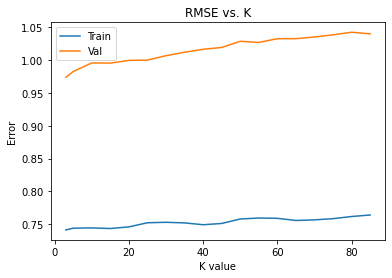

In [138]:
k_array = [3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
val_pivot = makePivot(val)

train_rmse_list, train_mae_list = [], []
val_rmse_list, val_mae_list = [], []

for k in k_array:
    
    train_filled, train_rmse, train_mae = evalTrain(train_pivot, k)
    val_rmse, val_mae = evalVal(val_pivot, train_filled)

    train_rmse_list.append(train_rmse)
    train_mae_list.append(train_mae)

    val_rmse_list.append(val_rmse)
    val_mae_list.append(val_mae)

plt.plot(k_array, train_rmse_list, label = 'Train')
plt.plot(k_array, val_rmse_list, label = 'Val')
plt.legend()
plt.title('RMSE vs. K')
plt.ylabel('Error')
plt.xlabel('K value')

Text(0.5, 0, 'K value')

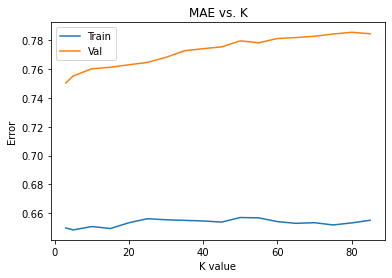

In [139]:
plt.plot(k_array, train_mae_list, label = 'Train')
plt.plot(k_array, val_mae_list, label = 'Val')
plt.legend()
plt.title('MAE vs. K')
plt.ylabel('Error')
plt.xlabel('K value')

In [86]:
## train
train_pivot = makePivot(train)
train_filled = compute_filled_matrix(train_pivot, 85)
mask = train_pivot.notna()
preds = train_filled.values[mask]
gt = train_pivot.values[mask]

print('-------------- Train ---------------')
print('RMSE: ', mean_squared_error(gt, preds, squared=False))
print('MAE: ', mean_absolute_error(gt, preds))

val_pivot = makePivot(val)
mask = val_pivot.notna()
preds = train_filled.values[mask]
gt = val_pivot.values[mask]
print('-------------- Val ---------------')
print('RMSE: ', mean_squared_error(gt, preds, squared=False))
print('MAE: ', mean_absolute_error(gt, preds))

-------------- Train ---------------
RMSE:  1.0407823407631073e-15
MAE:  7.053170055251964e-16
-------------- Val ---------------
RMSE:  1.0020195548272304
MAE:  0.7697720292369132


An improvement over the baselines on the train set but the rmse on our validation set is actually higher and the MAE is basically the same 
Lets try incorporating similar users

### Finding Similarities

In [87]:
def find_sim_users(filled_df, user):
    """
    Takes in the SVD array and the user of interest for whom we want
    to make recommendations 
    """
    # Normalize the reconstructed matrix 
    avg_ratings = filled_df.mean(axis=1)
    user_ratings_centered = filled_df.sub(avg_ratings, axis=0)
    similarities = cosine_similarity(user_ratings_centered)
    cosine_similarity_df = pd.DataFrame(similarities, index=user_ratings_centered.index, columns=user_ratings_centered.index)
    #cosine_similarity_df.head()

    # find the most similar users and return a sorted series 
    cosine_similarity_series = cosine_similarity_df.loc[user]
    ordered_similarities = cosine_similarity_series.sort_values(ascending=False)
    #print(ordered_similarities)

    return ordered_similarities

## Analyzing similarity results

I want to explore what the similar users look like before constructing a collaborative filter. I am just going to be looking at who similar the users are based on their actual ratings and which restaurants they have overlapped. Much more analysis can be done such as the categories of the restaurants that overlap but I am just going to do a basic analysis for now.

In [ ]:
user_of_interest = filtered_nola.loc[filtered_nola['user_id']=='-V7frksbFjKQYVhrPnnlPw']
user_highest_sim = filtered_nola.loc[filtered_nola['user_id']=='Il5rEF1q73uT-kzGoXIy_w']
overlap = user_of_interest[user_of_interest['business_id'].isin(user_highest_sim['business_id'])]

print('Mean rating for user of interst: ', np.mean(user_of_interest['stars']))
print('Number of restaurants in common: ', len(overlap))
print('Average star rating for restaurants in common for uoi: ', np.mean(overlap['stars']))

#overlap.head()

In [ ]:
user_highest_sim = filtered_nola.loc[filtered_nola['user_id']=='Il5rEF1q73uT-kzGoXIy_w']
overlap_user2 = user_highest_sim[user_highest_sim['business_id'].isin(user_of_interest['business_id'])]

print('Mean rating for user with highest similarity: ', np.mean(user_highest_sim['stars']))
print('Average star rating for restaurants in common for user 2: ', np.mean(overlap_user2['stars']))

#overlap_user2.head()

Although the users have 33 restaurants in common, their average rating is not very close to eachother as we would want (although they are pretty close). Perhaps a different value of K would solve this. Lets try to find which K recreates original matrix the best

In [ ]:
def calc_svd_for_k(k_array):
    """
    Iterates through values of K and calculates the distance between the reconstructed
    values computed through SVD and the original ground truth values
    """
    rmse_vals = []

    for val in k_array: 
        
        user_ratings_filled = compute_filled_matrix(val)

        predicted_ratings = user_ratings_filled.values
        gt_ratings = user_ratings_pivot.values
        mask = ~np.isnan(gt_ratings)
        rmse_vals.append(mean_squared_error(gt_ratings[mask],
                            predicted_ratings[mask],
                            squared=False))
        
    return rmse_vals

k_array = [3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85]
rmse_vals = calc_svd_for_k(k_array)

plt.plot(k_array, rmse_vals)
plt.title('RMSE vs. K')
plt.xlabel('Value of K')
plt.ylabel('RMSE')

It seems the lowest error is given by 85 latent vectors. This is to be expected as the entire matrix has a dimension of 87 and we are compressing the information only by 2 dimensions. In retrospect, I should have found the RMSE between the predicted restaurant rating and the ground truth restarant rating for different values of k instead of computing the reconstruction error. Anyways, Lets see if using 85 latent features leads to a more accurate similarity measurement

In [ ]:
user_ratings_filled_85 = compute_filled_matrix(85)
ordered_85 = find_sim_users(user_ratings_filled_85, '-V7frksbFjKQYVhrPnnlPw')
print(ordered_85)

...these correlations are much smaller than when using k = 10. This doesn't seem very promising, maybe the data is not compressed enough to find similarities even though the reconstruction error is the smallest. Lets look a little deeper into this

In [ ]:
user_of_interest = filtered_nola.loc[filtered_nola['user_id']=='-V7frksbFjKQYVhrPnnlPw']
user_highest_sim = filtered_nola.loc[filtered_nola['user_id']=='2BCqTs3dpcqAS6OOkaqYVA']
overlap = user_of_interest[user_of_interest['business_id'].isin(user_highest_sim['business_id'])]

print('Mean rating for user of interst: ', np.mean(user_of_interest['stars']))
print('Number of restaurants in common: ', len(overlap))
print('Average star rating for restaurants in common for uoi: ', np.mean(overlap['stars']))

#overlap.head(6)

In [ ]:
user_highest_sim = filtered_nola.loc[filtered_nola['user_id']=='2BCqTs3dpcqAS6OOkaqYVA']
overlap_user2 = user_highest_sim[user_highest_sim['business_id'].isin(user_of_interest['business_id'])]

print('Mean rating for user with highest similarity: ', np.mean(user_highest_sim['stars']))
print('Average star rating for restaurants in common for user 2: ', np.mean(overlap_user2['stars']))

#overlap_user2.head()

With a higher K, the similarity score is much lower, these users have less restaurants in common and their ratings are more differen compared to the user ranked as very similar with k = 10. Just out of curiousity, lets explore k = 35 since 35 is approximately halfway to 85 and also k = 3. Ideally, we would want stronger correlations to indicate stronger overlap.

In [ ]:
user_ratings_filled_35 = compute_filled_matrix(35)
ordered_35 = find_sim_users(user_ratings_filled_35, '-V7frksbFjKQYVhrPnnlPw')
print(ordered_35)

The most common user remained the same but has higher correlation values, indicating that perhaps with 85 vectors, the space is not compressed enough to find strong similarities. It is interesting to note that users in other places, such as the second and third most similar have changed. 

Now lets look at k = 3

In [ ]:
user_ratings_filled_3 = compute_filled_matrix(3)
ordered_3 = find_sim_users(user_ratings_filled_3, '-V7frksbFjKQYVhrPnnlPw')
#print(ordered_3)

In [ ]:
user_of_interest = filtered_nola.loc[filtered_nola['user_id']=='-V7frksbFjKQYVhrPnnlPw']
user_highest_sim = filtered_nola.loc[filtered_nola['user_id']=='h3ScdzD0VSUTQj492nIBLg']
overlap = user_of_interest[user_of_interest['business_id'].isin(user_highest_sim['business_id'])]

print('Mean rating for user of interst: ', np.mean(user_of_interest['stars']))
print('Number of restaurants in common: ', len(overlap))
print('Average star rating for restaurants in common for uoi: ', np.mean(overlap['stars']))

#overlap.head(6)

In [ ]:
user_highest_sim = filtered_nola.loc[filtered_nola['user_id']=='h3ScdzD0VSUTQj492nIBLg']
overlap_user2 = user_highest_sim[user_highest_sim['business_id'].isin(user_of_interest['business_id'])]

print('Mean rating for user with highest similarity: ', np.mean(user_highest_sim['stars']))
print('Average star rating for restaurants in common for user 2: ', np.mean(overlap_user2['stars']))

#overlap_user2.head()

With k = 3, the users have the furthest average ratings for restaurants they have in common even though their mean rating for all the restaurants is very similar. I think having a closer average rating for restaurants in common is more meaningful than having a closer rating overall so lets stick to k = 85 for our filter.

## Constructing the Recommender

For the final recommender, I am going to find the top 5 most similar users to user X, then find the overlap between those similar users and recommend the restaurant with the highest rating among all 5 users. Im going to try this for k = 3 based on analysis above and evaluate on the train and validation sets. I am a bit confused about how to use the validation hold out set to make predictions as we would want to use the values in the train set to find similar users and make predictions for the validation set but lets start of easy and just evaluate on the train set. 

In [ ]:
train_pivot.head()

In [88]:
user_of_interest = '-MRD72DXnVgjkM1AVFp7Nw'
ordered = find_sim_users(train_filled, user_of_interest)
ordered

user_id
-MRD72DXnVgjkM1AVFp7Nw    1.000000
0KvykeSkliujA79xITYLxw    0.338051
U6CknC8K0NTsXn_yLPV6tQ    0.268810
PiCDHUEBFFy8o3rKgWFDpw    0.245080
qMvJ_4Po6dYk-GX9pclRKg    0.199176
                            ...   
6lmqSrwSrhTcjNwTEiQZPg   -0.115701
vScaSrM91Z43ypSR9VfKGg   -0.124495
QGMX1H6WQTp-o8Qq3uO3dQ   -0.143505
KKpMFHF3-PFKTZP0ZPexfQ   -0.194943
iAJ15W0T6n1KMrSkGju3MQ   -0.238399
Name: -MRD72DXnVgjkM1AVFp7Nw, Length: 327, dtype: float64

In [89]:
top5 = ordered[:4].index.to_list()
weights = ordered[:4].values

sim_users = train_filled.loc[train_filled.index.isin(top5)]
avg_ratings = pd.DataFrame(sim_users.mean(axis=0)).T

user_of_interest = train_pivot.loc[train_pivot.index=='-MRD72DXnVgjkM1AVFp7Nw']

mask =user_of_interest.notna()
preds = avg_ratings.values[mask]
gt = user_of_interest.values[mask]

print(mean_squared_error(gt, preds, squared=False))
print(mean_squared_error(gt, preds))

0.5977230043348607
0.35727278991109196


### Defining functions to build a pipeline 

In [90]:
### functions for making the recommendation and then the entire pipeline from pivot table generation to recommendation 
def evaluateRecommendation(filled_df, split_df, user= None): 
    #find similar users in train set 
    ordered = find_sim_users(filled_df, user)
    #print(ordered[:3])
    # find top 5 most similar users 
    top_5 = ordered[:4].index
    weights = ordered[:4].values
    
    sim_users = filled_df.loc[filled_df.index.isin(top_5)]
    avg_ratings = pd.DataFrame(sim_users.mean(axis=0)).T

    user_of_interest = split_df.loc[split_df.index==user]
    mask =user_of_interest.notna()
    preds = avg_ratings.values[mask]
    gt = user_of_interest.values[mask]

    # print(gt)
    # print(preds)


    # print('gt: ', gt)
    # Since we are going to recommend the top 5 restaurants, we are only evaluating on the top 5 in the sorted ratings 
    rmse = mean_squared_error(gt, preds, squared=False)
    mae = mean_absolute_error(gt, preds)
    #print('Predictions: ', prediction)
    #print('Ground truth: ', gt)

    return rmse, mae

### Validating the recommendation algorithm on the train set 


In [91]:
train_filled = compute_filled_matrix(train_pivot, 85)
rmse, mae = evaluateRecommendation(train_filled, train_pivot, user= '-V7frksbFjKQYVhrPnnlPw')
print('RMSE: ', rmse)
print('MAE: ', mae)

RMSE:  0.5193288016896416
MAE:  0.3794060566419678


In [92]:
## entire pipeline
mse = []
mae = []

users_of_interest = train['user_id'].unique()
for user in users_of_interest:

    user_rmse, user_mae = evaluateRecommendation(train_filled, train_pivot, user)

    mse.append(user_rmse)
    mae.append(user_mae)

print('Average mean squared error: ', np.round(np.mean(mse),2))
print('Average mean absolute error: ', np.round(np.mean(mae),2))

Average mean squared error:  0.68
Average mean absolute error:  0.56


We beat the baseline on both metrics! Now, lets try the validation set. Essentially, to evaluate the validation set we want to 

1. Find which users in the train set are similar to the users in the validation set as the validation is the "new user" information that we want to make predictions for 
2. Use the ratings of users in the train set to predict the rating in the validation set
3. Compare the gt in the validation set to the prediction made my similar users in the train set 

I don't think it makes sense to use the validation set to make predictions for the validation set as then in that case, that would have been the same as keeping the validation set and the train set together in the first place. We want to see if we can preict ratings of restaurants we haven't seen before for users we have seen before. I'm going to need to change the functions above slightly so instead of making one ginormous function I will just define slightly modified functions called evaluateRecommendation

### Evaluating recommendation engine on validation set

In [93]:
rmse, mae = evaluateRecommendation(train_filled, val_pivot, user = '-V7frksbFjKQYVhrPnnlPw')
print('RMSE: ', rmse)
print('MAE: ', mae)

RMSE:  0.6603628740286661
MAE:  0.45491256481776865


In [94]:
## entire pipeline
mse = []
mae = []

users_of_interest = val['user_id'].unique()
for user in users_of_interest:

    user_rmse, user_mae = evaluateRecommendation(train_filled, val_pivot, user)

    mse.append(user_rmse)
    mae.append(user_mae)

print('Average mean squared error: ', np.round(np.mean(mse),2))
print('Average mean absolute error: ', np.round(np.mean(mae),2))


Average mean squared error:  0.98
Average mean absolute error:  0.8


Now lets try to find the most optimal value of k based on the predictions and see if it matches our earlier analysis

In [ ]:
avg_mse = []
avg_mae = []
k_array = [3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 86]
for k in k_array:

    train_filled = computeFilledMatrix(k)
    rmse = []
    mae = []

    for user in users_of_interest:
       
        user_rmse, user_mae = evaluateRecommendation(train_filled, val_pivot, user)
        rmse.append(user_rmse)
        mae.append(user_mae)

    avg_mse.append(np.round(np.mean(rmse),2))
    avg_mae.append(np.round(np.mean(mae),2))

plt.plot(k_array, avg_mse, label = 'Avg MSE')
plt.plot(k_array, avg_mae, label = 'Avg MAE')
plt.legend()
plt.title('Average Error vs. K')
plt.ylabel('Average Error')
plt.xlabel('K value')

In [ ]:
print(min(avg_mse))
print(min(avg_mae))

## Final Recommender System

In [ ]:
### functions for making the recommendation 
def makeRecommendation(ordered, split_df, user): 

    top_10 = ordered[1:6].index
    user_of_interest = split_df.loc[split_df['user_id']==user]
    rest_ratings_dict = {}
    rest_counts_dict = {}

    for user in top_10: 
        #print(user)
        user_highest_sim = split_df.loc[split_df['user_id']==user]
        new_rests = user_highest_sim[~user_highest_sim['business_id'].isin(user_of_interest['business_id'])]
        for business in new_rests['business_id'].unique():
            if business in rest_ratings_dict.keys(): 
                # print(business)
                rest_ratings_dict[business] += new_rests['stars'].loc[new_rests['business_id']==business].mean()
                rest_counts_dict[business] += 1
            else: 
                rest_ratings_dict[business] = new_rests['stars'].loc[new_rests['business_id']==business].mean()
                rest_counts_dict[business] = 1

    for k,v in list(rest_counts_dict.items()):
        if v == 1:
            del rest_counts_dict[k]
            del rest_ratings_dict[k]

    averaged_ratings = {k: rest_ratings_dict[k]/rest_counts_dict[k] for k in rest_counts_dict.keys() & rest_ratings_dict}
    top5_ratings = dict(sorted(averaged_ratings.items(), key=lambda item: item[1], reverse = True))

    print('Based on users with similar interests, we recommend the following restaurants for you:')
    for i, biz in enumerate(top5_ratings.keys()):
        if i < 6: 
            print('Recommendation {}: {}'.format(i, biz_dict[biz]))
        else: 
            break
